In [1]:
from utils import reactjs
from utils.display import show_features, show_image, feature_detect_and_show
reactjs.css()

In [2]:
import abc 
from typing import List
from utils.cropengine import Feature 

FileName = str 

class FeatureDetector(abc.ABC):    
    @abc.abstractmethod
    def __init__(self, n:int, size:int) -> None:
        ...

    @abc.abstractmethod
    def detect_features(self, fn: FileName) -> List[Feature]:
        ...

In [3]:
import cv2
import numpy

CVImage = numpy.ndarray

def opencv_image(fn: str, resize: int=0) -> CVImage:
    cv_image = cv2.imread(fn)
    cv_image = cv2.cvtColor(
        cv_image, cv2.COLOR_BGR2GRAY)
    if resize > 0:
        w, h = cv_image.shape[1::-1]  # type: int, int
        multiplier = (resize ** 2 / (w * h)) ** 0.5
        dimensions = tuple(
            int(round(d * multiplier)) for d in (w, h))
        cv_image = cv2.resize(
            cv_image, dimensions,
            interpolation=cv2.INTER_AREA)
    return cv_image

def resize_feature(feature: Feature, cv_image: CVImage) -> Feature:
    img_h, img_w = cv_image.shape[:2]  # type: int, int
    feature = Feature(
        label=feature.label,
        weight=feature.weight / (img_w * img_h),
        left=max(0, feature.left / img_w),
        top=max(0, feature.top / img_h),
        right=min(1, feature.right / img_w),
        bottom=min(1, feature.bottom / img_h),
    )
    return feature


In [4]:
panda_house = 'img/panda.jpg'
show_image(panda_house)


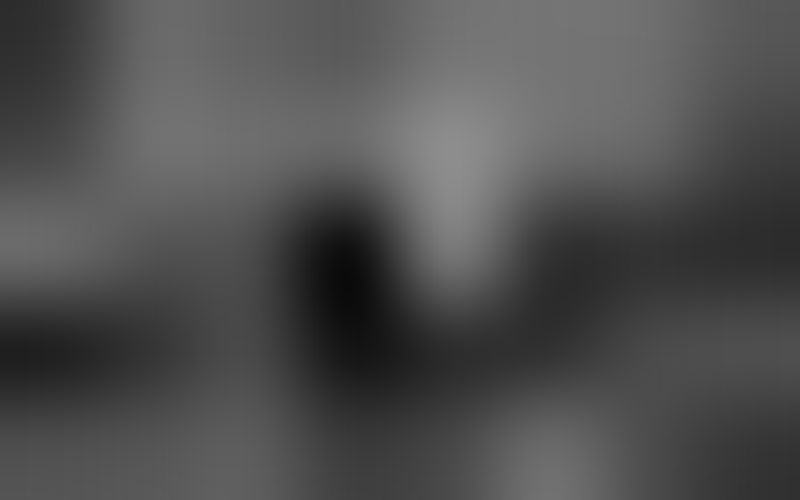

In [5]:
img_array = opencv_image(panda_house, 6)
show_image(img_array) # convert to png and display

In [6]:
img_array

array([[ 53, 104,  99,  91, 116, 116, 110,  87],
       [ 73, 111, 109, 104, 141, 112, 100,  66],
       [104,  84,  76,  17, 119,  52,  51,  45],
       [ 33,  53,  72,  21,  45,  50,  73,  78],
       [ 79,  85,  92,  60,  72, 106,  76,  54]], dtype=uint8)

In [7]:
data = [
  {
    "label": "keypoint one",
    "x": 0.25,
    "y": 0.25,
    "width": 0.30,
    "height": 0.50,
    "weight": 2
  },
  {
    "label": "keypoint two",
    "x": 0.20,
    "y": 0.20,
    "width": 0.15,
    "height": 0.25,
    "weight": 1
  }
]

In [8]:
features = [Feature.deserialize(item) for item in data]
show_features(panda_house, features)

In [9]:
features[0] * 0.4

Feature(weight=0.8, label='keypoint one', left=0.34, top=0.4, right=0.46, bottom=0.6)

In [10]:
features[0] + features[1]

Box(left=0.2, top=0.2, right=0.55, bottom=0.75)

In [11]:
features[0] & features[1]

Box(left=0.25, top=0.25, right=0.35, bottom=0.45)

In [12]:
FeatureDetector._opencv_image = staticmethod(opencv_image)
FeatureDetector._resize_feature = staticmethod(resize_feature)

In [13]:
class MFeatureDetector(FeatureDetector):
    def __init__(self, n: int=3, size: int=200) -> None:
        self._number = n
        self._size = size
        self._circles = [m / n for m in range(1, n + 1)]

    def detect_features(self, fn: FileName) -> List[Feature]:
        cv_image = self._opencv_image(fn, self._size)
        img_h, img_w = cv_image.shape[:2]  
        middle = Feature(0, 'mock keypoint', 0, 0, img_w, img_h)
        middle.width = middle.height = min(img_w, img_h)
        middle = self._resize_feature(middle, cv_image)
        return [middle * size for size in self._circles]

def show_features(image_file: FileName, detector: FeatureDetector):
    features = detector.detect_features(image_file)
    return render(image_file, features)

input_image = 'img/panda.jpg'
feature_detect_and_show(input_image, MFeatureDetector())

In [14]:
image_array = cv2.imread(input_image)
orb_detector = cv2.ORB_create(3)
keypoints = orb_detector.detect(image_array)
keypoints

(< cv2.KeyPoint 0000020BC0E37240>,
 < cv2.KeyPoint 0000020BC0E37ED0>,
 < cv2.KeyPoint 0000020BC0E379F0>)

In [15]:
kp = keypoints[0]
print('\n'.join('kp.{:10}: {}'.format(attr, getattr(kp, attr)) 
                for attr in dir(kp) if not attr.startswith('_')))

kp.angle     : 24.15765380859375
kp.class_id  : -1
kp.convert   : <built-in method convert of type object at 0x0000020BB8501FA0>
kp.octave    : 0
kp.overlap   : <built-in method overlap of type object at 0x0000020BB8501FA0>
kp.pt        : (658.0, 310.0)
kp.response  : 0.000883500964846462
kp.size      : 31.0


In [16]:
class KeypointDetector(FeatureDetector):

    LABEL = 'ORB keypoint'

    def __init__(self, n: int=10, padding: float=1.0,
                 imagesize: int=200, **kwargs) -> None:
        self._imagesize = imagesize
        self._padding = padding
        kwargs = {
            "nfeatures": n + 1,
            "scaleFactor": 1.5,
            "patchSize": self._imagesize // 10,
            "edgeThreshold": self._imagesize // 10,
            "scoreType": cv2.ORB_FAST_SCORE,
            **kwargs,
        }
        self._detector = cv2.ORB_create(**kwargs)

    def detect_features(self, fn: str) -> List[Feature]:
        cv_image = self._opencv_image(fn, self._imagesize)
        keypoints = self._detector.detect(cv_image)
        features = []
        for kp in keypoints:
            ft = self._keypoint_to_feature(kp) 
            ft = self._resize_feature(ft, cv_image)
            features.append(ft)
        return sorted(features, reverse=True)

    def _keypoint_to_feature(self, kp: cv2.KeyPoint) -> Feature:
        x, y = kp.pt
        radius = kp.size / 2
        weight = radius * kp.response ** 2
        return Feature(
            label=self.LABEL,
            weight=weight,
            left=x - radius,
            top=y - radius,
            right=x + radius,
            bottom=y + radius
        ) * self._padding
    

In [17]:
panda_image = 'img/panda.jpg'
detector = KeypointDetector()
feature_detect_and_show(panda_image, detector)


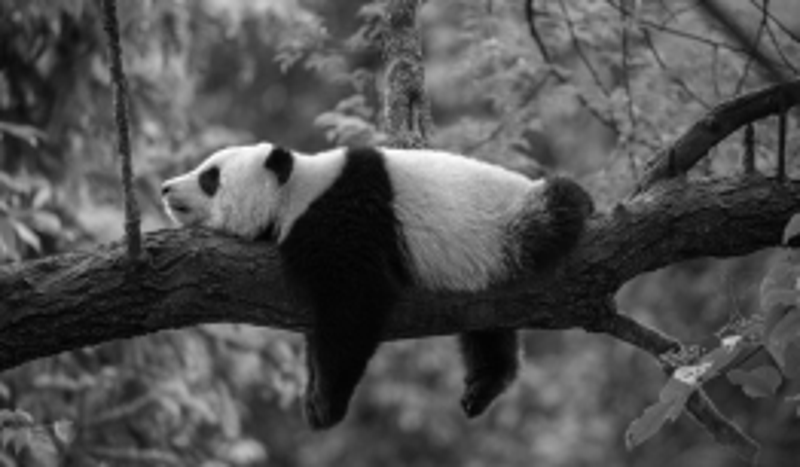

In [18]:
show_image(opencv_image(panda_image, 200))

In [19]:
detector2 = KeypointDetector(imagesize=2000)
feature_detect_and_show(panda_image, detector2)

In [20]:
detector3 = KeypointDetector(
    n=100, imagesize=2000, patchSize=30, edgeThreshold=30)
feature_detect_and_show(panda_image, detector3)

In [21]:
feature_detect_and_show(input_image, detector)

In [22]:
image_array = cv2.imread(panda_image)
cascade_file = 'C:\\Users\\Soleyman\\AppData\\Local\\Programs\\Python\\Python39\\share\\OpenCV\\haarcascades\\haarcascade_frontalcatface.xml'
viola_jones_classifier = cv2.CascadeClassifier(cascade_file)

viola_jones_classifier.detectMultiScale(image_array)

array([[21, 28, 30, 30]])

In [23]:
class Cascade:

    _DIR = 'C:\\Users\\Soleyman\\AppData\\Local\\Programs\\Python\\Python39\\share\\OpenCV\\haarcascades\\'

    def __init__(self, label: str, fn: FileName,
                 size: float=1, weight: float=100) -> None:
        self.label = label
        self.size = size
        self.weight = weight
        self._file = self._DIR + fn
        self.classifier = cv2.CascadeClassifier(self._file)
        if self.classifier.empty():
            msg = ('The input file: "{}" is not a valid '
                   'cascade classifier').format(self._file)
            raise RuntimeError(msg)

In [24]:
class FaceDetector(FeatureDetector):

    _CASCADES = [
        Cascade('frontal face',
                'haarcascade_frontalface_default.xml',
                size=1.0, weight=100),
        Cascade('alt face',
                'haarcascade_frontalface_alt_tree.xml',
                size=0.8, weight=100),
        Cascade('profile face',
                'haarcascade_profileface.xml',
                size=0.9, weight=50),
    ]

    def __init__(self, n: int=100, padding: float=1.2,
                 imagesize: int=610, **kwargs) -> None:
        self._number = n
        self._imagesize = imagesize
        self._padding = padding
        self._cascades = self._CASCADES
        minsize = max(25, imagesize // 25)
        self._kwargs = {
            "minSize": (minsize, minsize),
            "scaleFactor": 1.1,
            "minNeighbors": 5,
        }
        self._kwargs.update(kwargs)

    def detect_features(self, fn: FileName) -> List[Feature]:
        """Find faces in the image."""
        features = []  # type: List[Feature]
        cv_image = self._opencv_image(fn, self._imagesize)

        for cascade in self._cascades:
            padding = self._padding * cascade.size
            detect = cascade.classifier.detectMultiScale
            faces = detect(cv_image, **self._kwargs)

            for left, top, width, height in faces:
                weight = height * width * cascade.weight
                face = Feature(
                    label=cascade.label,
                    weight=weight,
                    left=left,
                    top=top,
                    right=left + width,
                    bottom=top + height,
                )
                face = face * padding
                face = self._resize_feature(face, cv_image)
                features.append(face)

        return sorted(features, reverse=True)[:self._number]

In [25]:
feature_detect_and_show(input_image, FaceDetector())

In [26]:
g_face_detector = FaceDetector(minNeighbors=0)
feature_detect_and_show(input_image, g_face_detector)

In [27]:
feature_detect_and_show('img/panda1.jpg', g_face_detector)

In [28]:
feature_detect_and_show('img/panda2.jpg', FaceDetector())

In [37]:
class HybridDetector(FeatureDetector):

    BREAKPOINT = 0.15

    def __init__(self, n=10) -> None:
        self.primary = FaceDetector(n, padding=1.5)
        self.fallback = KeypointDetector(n, padding=1.2)
        self.breakpoint = self.BREAKPOINT
        self._number = n

    def detect_features(self, fn: FileName) -> List[Feature]:
        faces = self.primary.detect_features(fn)
        if faces and sum(faces).size > self.breakpoint:
            return faces
        features = faces + self.fallback.detect_features(fn)
        return features[:self._number]

In [38]:
feature_detect_and_show('img/panda1.jpg', HybridDetector())

In [31]:
images = [ 
    'img/panda1.jpg',
    'img/panda2.jpeg',
    'img/panda2.jpg',
    'img/panda3.jpg',
    'img/panda4.jpg'
]
detector = HybridDetector()
feature_detect_and_show(images, HybridDetector(), preview=True)